# 미니 프로젝트 1

## 서울시 공유자전거인 '따릉이'의 수요와 날씨간 연관성 분석하기
- 어떤 날씨요소가 따릉이 수요와 관련 있는지 분석하여 인사이트를 도출해보자.
- 공공데이터 출처
    1. 서울시 공공자전거 시간대별 이용정보 (출처 : 서울시 열린데이터 광장)
    2. 시간별 날씨 자료 (출처 : 기상자료개방포털)

### 데이터 정보
- 기본 데이터 : sbikedata.csv
    1. 기간 : 2021.4~11월 (8개월)
    2. 장소 : 서울시 마포구로 한정
    3. 데이터셋 변수 정보
        * date : 날짜
        * hour : 시간
        * temperature : 온도
        * precipitation : 강우 여부, 비가 오지 않았으면 0, 비가 오면 1
        * windspeed : 풍속(평균)
        * humidity : 습도
        * visibility : 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
        * ozone : 오존 수치
        * PM10 : 미세먼지 수치(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
        * PM2.5 : 초미세먼지 수치(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
        * **count : 시간에 따른 따릉이 대여 수(<-Target)**
    

## 1. 데이터 불러오기

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as spst

In [6]:
sbike = pd.read_csv("data/sbikedata.csv")

In [7]:
sbike.head()

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
0,2021-04-01,1,42.0,21.0,0.002,13.1,0,1.4,49,2000,46
1,2021-04-01,2,41.0,21.0,0.003,12.4,0,2.1,53,2000,40
2,2021-04-01,3,30.0,13.0,0.023,13.1,0,3.4,43,2000,31
3,2021-04-01,4,27.0,12.0,0.028,13.0,0,3.1,44,2000,12
4,2021-04-01,5,29.0,14.0,0.008,13.0,0,2.9,44,2000,30


In [9]:
sbike['date'] = pd.to_datetime(sbike['date'])
sbike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5827 entries, 0 to 5826
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           5827 non-null   datetime64[ns]
 1   hour           5827 non-null   int64         
 2   PM10           5725 non-null   float64       
 3   PM2.5          5732 non-null   float64       
 4   ozone          5699 non-null   float64       
 5   temperature    5827 non-null   float64       
 6   precipitation  5827 non-null   int64         
 7   windspeed      5827 non-null   float64       
 8   humidity       5827 non-null   int64         
 9   visibility     5827 non-null   int64         
 10  count          5827 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(5)
memory usage: 500.9 KB


- 분석단위 : 5827개의 시간대 별 날씨 및 따릉이 대여량 , 11개의 정보

In [10]:
# 결측치 확인
sbike.isna().sum()

date               0
hour               0
PM10             102
PM2.5             95
ozone            128
temperature        0
precipitation      0
windspeed          0
humidity           0
visibility         0
count              0
dtype: int64

- 결측치 처리 방안 : 해당 변수 사용시에만 결측치 빼고 분석

## 2. 가설설정
귀무가설,대립가설이란?
- 귀무가설은 차이가 없다, 연관성이 없다, 효과가 없다.
- 대립가설은 차이가 있다, 연관성이 있다, 효과가 있다.

Target은 따릉이 대여량으로 고정한다.
- 가설1 : 온도와 따릉이 대여량 간에는 연관성이 있다. (비오는 날 제외)
- 가설2 : 습도와 따릉이 대여량 간에는 연관성이 있다. (비오는 날 제외)
- 가설3 : 불쾌지수와 따릉이 대여량 간에는 연관성이 있다.
- 가설4 : 평일/주말과 대여량 간에는 연관성이 있다.
- 가설5 : 미세먼지 예보와 대여량 간에는 연관성이 있다.

## 3. 단변량 분석

In [28]:
def histbox (x, data, bins = 20):
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    sns.histplot(data[x],kde=True,bins=bins)
    
    plt.subplot(1,2,2)
    sns.boxplot(data[x])
    plt.show()

### Feature1 : hour

In [30]:
sbike['hour'].describe()

count    5827.000000
mean       11.506607
std         6.921963
min         0.000000
25%         6.000000
50%        12.000000
75%        18.000000
max        23.000000
Name: hour, dtype: float64

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


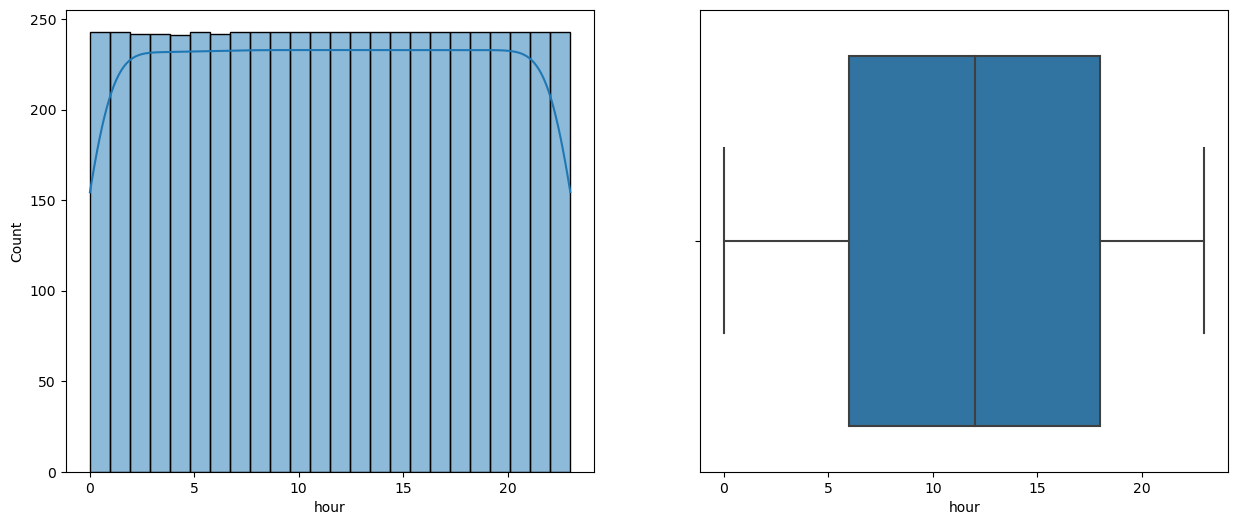

In [31]:
histbox('hour',sbike,bins=24)

### Feature2 : temperature

In [32]:
sbike['temperature'].dtype

dtype('float64')

In [33]:
sbike['temperature'].isna().sum()

0

In [34]:
sbike['temperature'].describe()

count    5827.000000
mean       19.376798
std         7.501572
min        -3.500000
25%        14.100000
50%        20.400000
75%        24.900000
max        36.300000
Name: temperature, dtype: float64

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


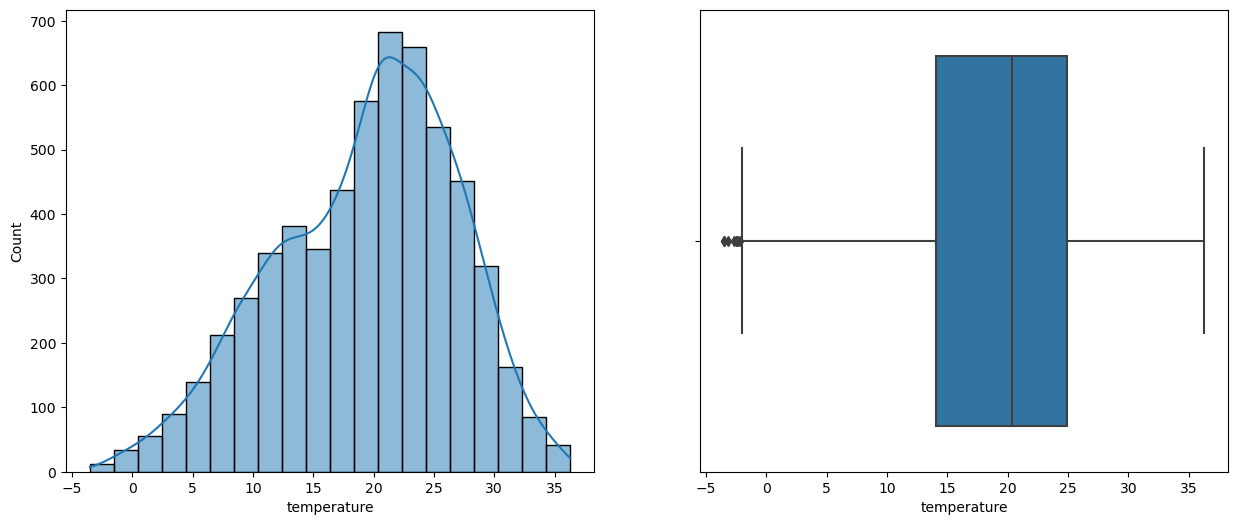

In [35]:
histbox('temperature',sbike)

### Feature3 : precipitation

<AxesSubplot:xlabel='precipitation', ylabel='count'>

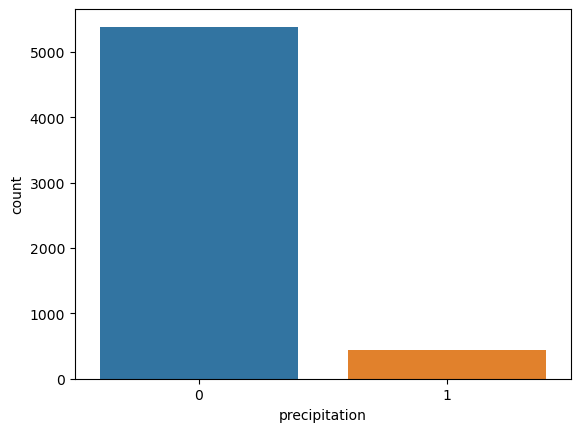

In [36]:
sns.countplot(x = sbike['precipitation'])

In [39]:
#강우 비율 - 7%
sbike['precipitation'].value_counts()/sbike.shape[0]

0    0.924489
1    0.075511
Name: precipitation, dtype: float64

In [41]:
#여름에 강우 비율은?
summer = sbike.loc[sbike['date'].dt.month.isin([6,7,8])]
summer

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
1460,2021-06-01,0,41.0,20.0,0.006,19.8,0,0.9,79,1947,76
1461,2021-06-01,1,40.0,24.0,0.012,19.1,0,2.0,84,1487,58
1462,2021-06-01,2,38.0,24.0,0.020,18.8,0,1.7,84,1757,37
1463,2021-06-01,3,38.0,21.0,0.022,18.8,0,1.6,86,2000,29
1464,2021-06-01,4,38.0,22.0,0.022,18.9,0,1.3,84,2000,24
...,...,...,...,...,...,...,...,...,...,...,...
3663,2021-08-31,19,14.0,10.0,0.030,18.1,1,3.9,98,843,8
3664,2021-08-31,20,12.0,7.0,0.033,18.1,1,4.3,99,438,9
3665,2021-08-31,21,10.0,6.0,0.032,18.1,1,3.8,99,407,6
3666,2021-08-31,22,11.0,5.0,0.029,18.3,1,3.3,100,778,4


<AxesSubplot:xlabel='precipitation', ylabel='count'>

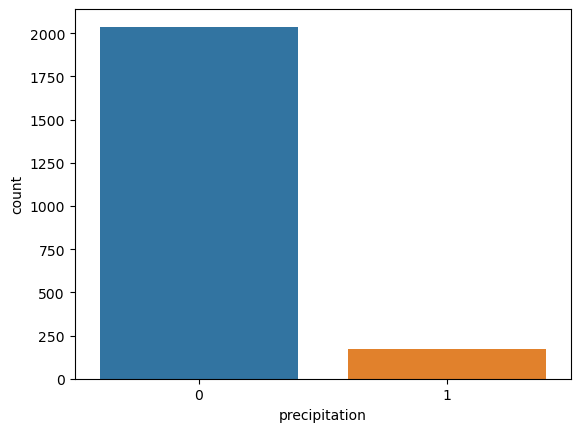

In [42]:
sns.countplot(x = summer['precipitation'])

In [44]:
#여름에 강우 비율 - 약 7% (크게 차이 없음)
summer['precipitation'].value_counts()/summer.shape[0]

0    0.923007
1    0.076993
Name: precipitation, dtype: float64

### Feature4 : windspeed

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


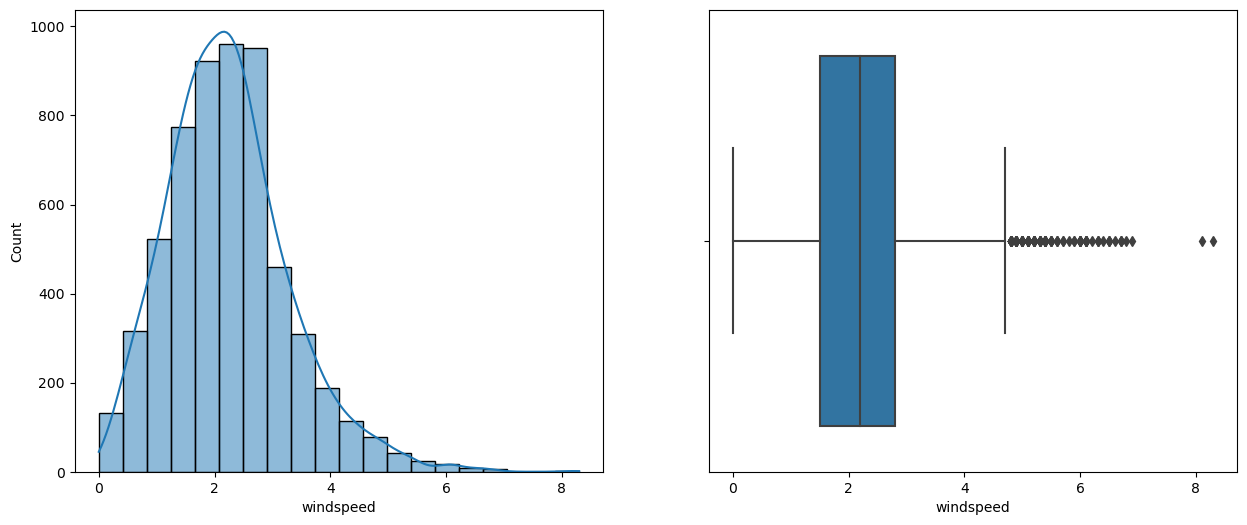

In [45]:
histbox('windspeed',sbike)

### Feature5 : humidity

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


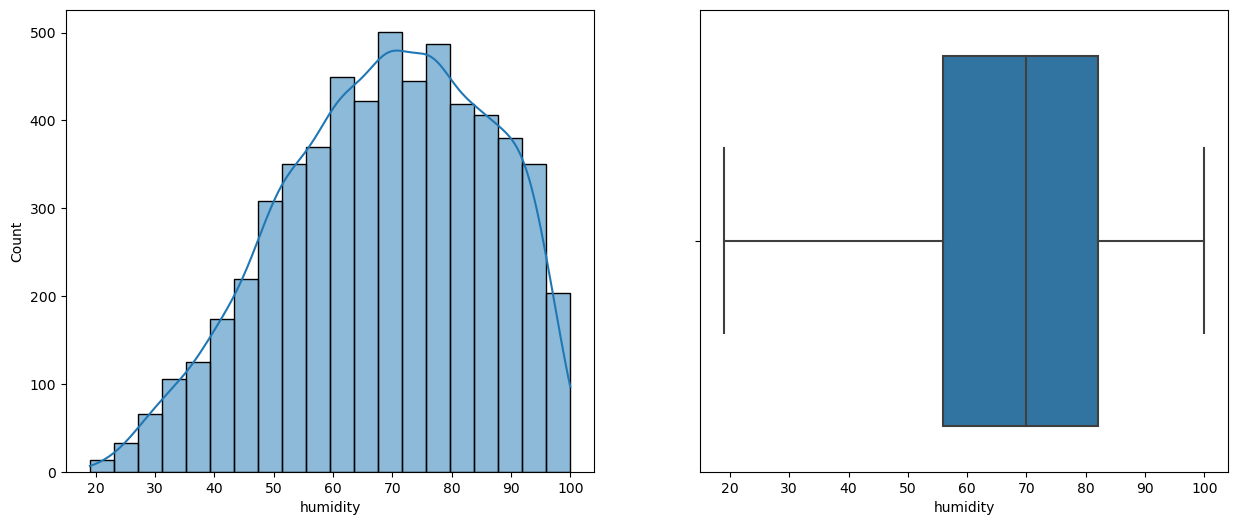

In [47]:
histbox('humidity',sbike)

### Feature6 : visibility

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


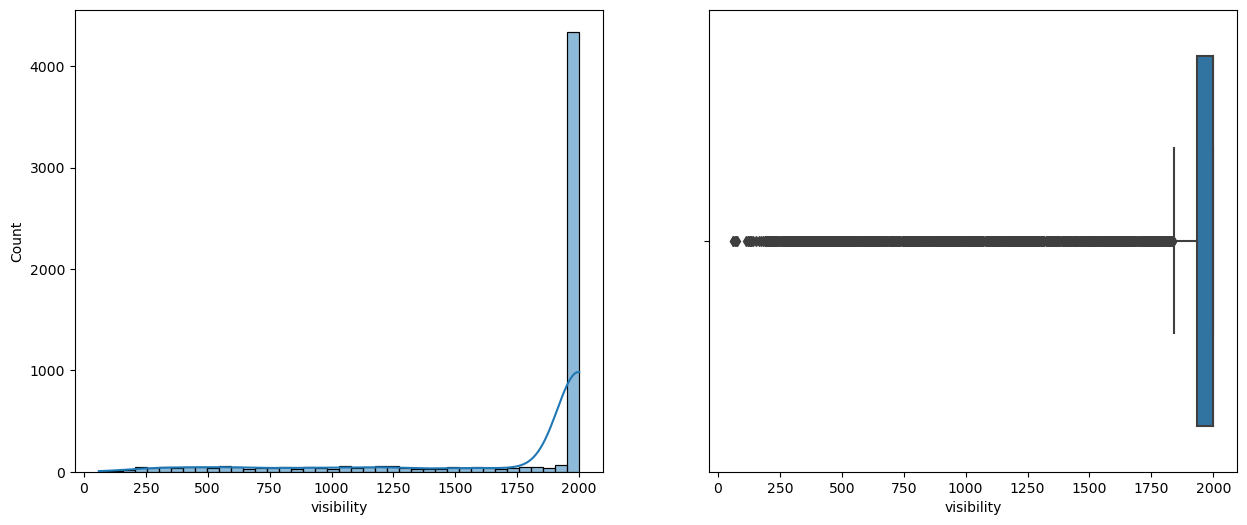

In [49]:
histbox('visibility',sbike,bins=40)

약 2000 에 대부분 몰려있음! -> 실제로 값이 2000이상인 데이터는 모두 2000으로 기재되어있다. 

### Feature7 : ozone

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


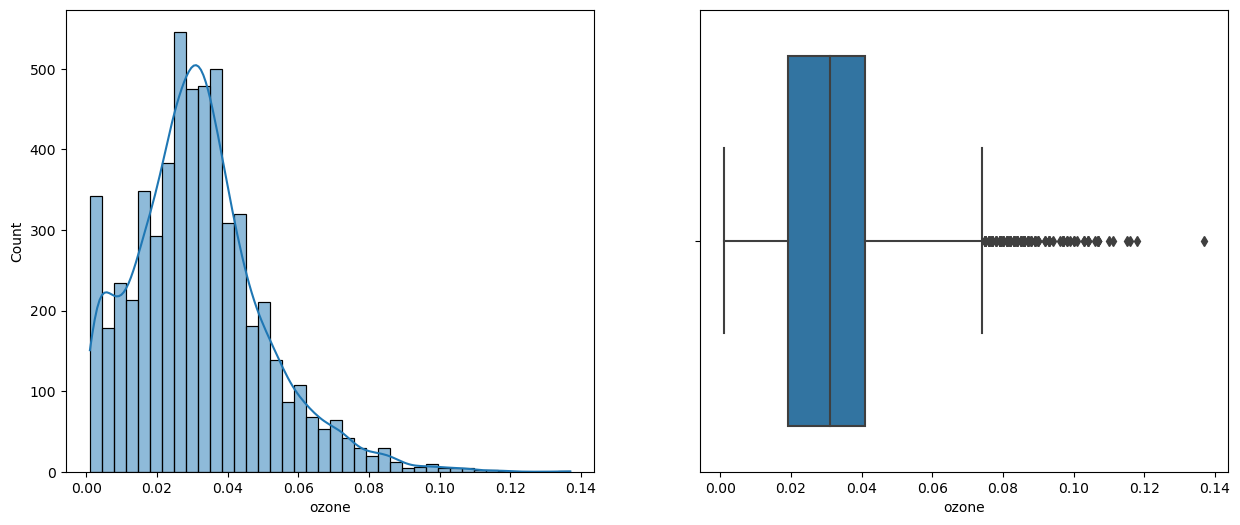

In [50]:
histbox('ozone',sbike,bins=40)

In [51]:
sbike['ozone'].describe()

count    5699.000000
mean        0.031811
std         0.018277
min         0.001000
25%         0.019000
50%         0.031000
75%         0.041000
max         0.137000
Name: ozone, dtype: float64

### Feature8 : PM10

In [52]:
sbike['PM10'].isna().sum()

102

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


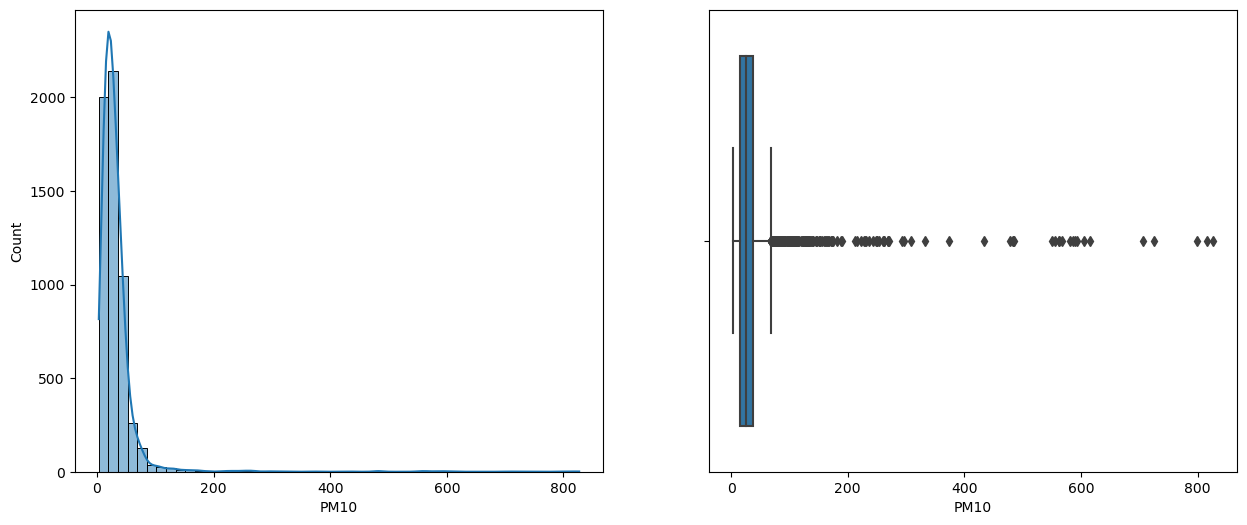

In [53]:
histbox('PM10',sbike,bins=50)

In [55]:
sbike.loc[sbike['PM10'].isnull()]

,date,hour,PM10,PM2.5,ozone,temperature,precipitation,windspeed,humidity,visibility,count
274,2021-04-12,11,NaN,NaN,NaN,16.9,0,2.8,41,2000,117
275,2021-04-12,12,NaN,NaN,NaN,17.6,0,3.9,39,2000,73
276,2021-04-12,13,NaN,NaN,0.038,16.6,0,3.8,48,1974,10
538,2021-04-23,11,NaN,NaN,NaN,20.5,0,4.4,42,2000,261
539,2021-04-23,12,NaN,NaN,NaN,20.6,0,4.4,32,2000,258
...,...,...,...,...,...,...,...,...,...,...,...
5147,2021-11-01,17,NaN,NaN,NaN,14.8,0,2.6,61,2000,525
5503,2021-11-16,13,NaN,NaN,NaN,12.5,0,2.6,36,2000,227
5504,2021-11-16,14,NaN,NaN,NaN,13.3,0,2.9,35,2000,178
5505,2021-11-16,15,NaN,NaN,NaN,13.3,0,3.3,37,2000,233


PM10의 결측치 데이터만 뽑아봤더니 대부분 PM2.5와 오존도 결측치이다.

### Feature9 : PM2.5

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


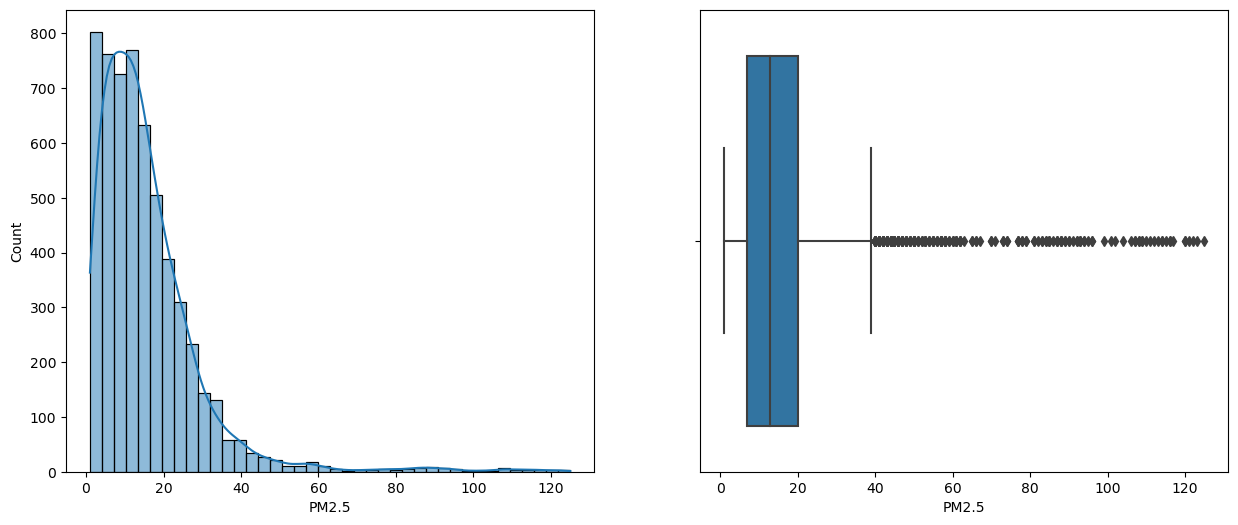

In [56]:
histbox('PM2.5',sbike,bins=40)

### count (Target)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


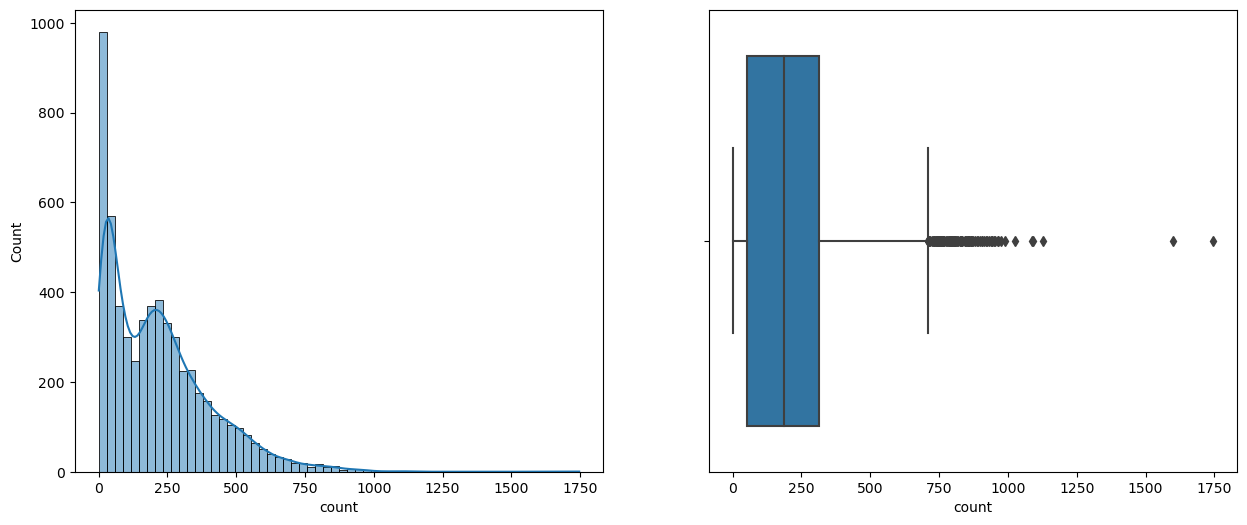

In [57]:
histbox('count',sbike,bins=60)